 
Created on Sun Apr 19 08:57:13 2015 
 
@author: shifeng 




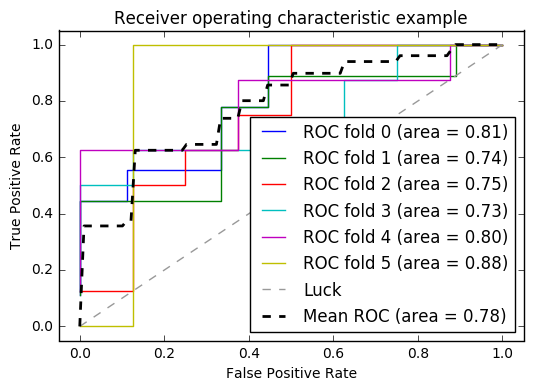

In [6]:
# -*- coding: utf-8 -*-  
""" 
Created on Sun Apr 19 08:57:13 2015 
 
@author: shifeng 

"""  
print(__doc__)  
  
import numpy as np  
from scipy import interp  
import matplotlib.pyplot as plt  
  
from sklearn import svm, datasets  
from sklearn.metrics import roc_curve, auc  
from sklearn.cross_validation import StratifiedKFold  
  
###############################################################################  
# Data IO and generation,导入iris数据，做数据准备  
  
# import some data to play with  
iris = datasets.load_iris()  
X = iris.data  
y = iris.target  
X, y = X[y != 2], y[y != 2]#去掉了label为2，label只能二分，才可以。  
n_samples, n_features = X.shape  
  
# Add noisy features  
random_state = np.random.RandomState(0)  
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]  
  
###############################################################################  
# Classification and ROC analysis  
#分类，做ROC分析  
  
# Run classifier with cross-validation and plot ROC curves  
#使用6折交叉验证，并且画ROC曲线  
cv = StratifiedKFold(y, n_folds=6)  
classifier = svm.SVC(kernel='linear', probability=True,  
                     random_state=random_state)#注意这里，probability=True,需要，不然预测的时候会出现异常。另外rbf核效果更好些。  
  
mean_tpr = 0.0  
mean_fpr = np.linspace(0, 1, 100)  
all_tpr = []  
  
for i, (train, test) in enumerate(cv):  
    #通过训练数据，使用svm线性核建立模型，并对测试集进行测试，求出预测得分  
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])  
#    print set(y[train])                     #set([0,1]) 即label有两个类别  
#    print len(X[train]),len(X[test])        #训练集有84个，测试集有16个  
#    print "++",probas_                      #predict_proba()函数输出的是测试集在lael各类别上的置信度，  
#    #在哪个类别上的置信度高，则分为哪类  
    # Compute ROC curve and area the curve  
    #通过roc_curve()函数，求出fpr和tpr，以及阈值  
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])  
    mean_tpr += interp(mean_fpr, fpr, tpr)          #对mean_tpr在mean_fpr处进行插值，通过scipy包调用interp()函数  
    mean_tpr[0] = 0.0                               #初始处为0  
    roc_auc = auc(fpr, tpr)  
    #画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来  
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))  
  
#画对角线  
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')  
  
mean_tpr /= len(cv)                     #在mean_fpr100个点，每个点处插值插值多次取平均  
mean_tpr[-1] = 1.0                      #坐标最后一个点为（1,1）  
mean_auc = auc(mean_fpr, mean_tpr)      #计算平均AUC值  
#画平均ROC曲线  
#print mean_fpr,len(mean_fpr)  
#print mean_tpr  
plt.plot(mean_fpr, mean_tpr, 'k--',  
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)  
  
plt.xlim([-0.05, 1.05])  
plt.ylim([-0.05, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Receiver operating characteristic example')  
plt.legend(loc="lower right")  
plt.show()  

 
Created on Sun Apr 19 08:57:13 2015 
 
@author: shifeng 




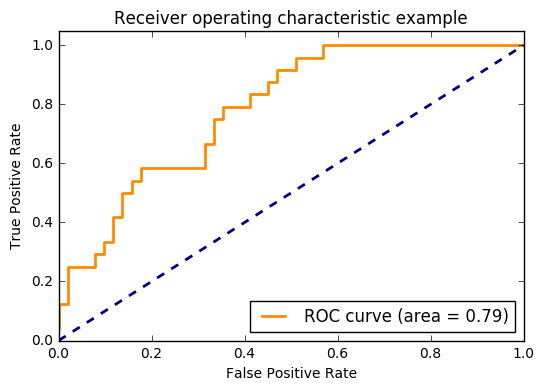

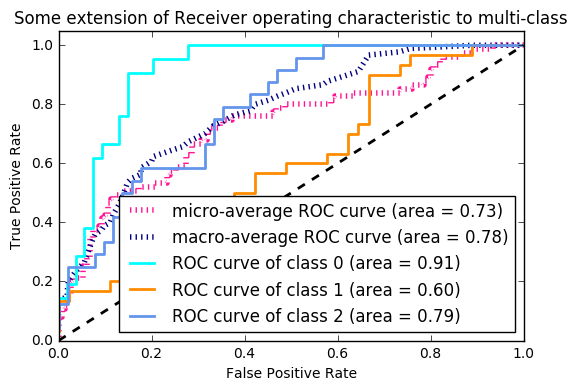

In [10]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
# ../../_images/sphx_glr_plot_roc_001.png
# Plot ROC curves for the multiclass problem
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()